---

# K-Means Clustering
###  Generalized k-means analysis
### Clustering node sensor temperature readings into potentially 'seasons'


---

<br>

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the code raw output (charts, plots, tables, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

In [2]:
print('Use this toggle button, it really helps')

Use this toggle button, it really helps


<br>

Importing libraries:

In [196]:
import warnings  
warnings.filterwarnings('ignore')
import os
import dask 
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode 
from plotly.offline import plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.io as pio
import re 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# sns.set_style("white")

Moving directories:

In [4]:
%cd D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12    

D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12


Reading in large datafile:

In [5]:
df = pd.read_csv('use_for_UML.csv', index_col  = ['timestamp'])  # 1.8M rows

I will keep the seperate timestamp col T for my plots whenever using the index is more difficult

In [6]:
df.head()
df.tail()

,sensor,value_hrf,T
timestamp,,,
2018-05-01 00:00:18,bmp180,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,bmp180,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,bmp180,30.4,2018-05-01 00:01:10
2018-05-01 00:01:35,bmp180,30.3,2018-05-01 00:01:35
2018-05-01 00:02:01,bmp180,30.4,2018-05-01 00:02:01


,sensor,value_hrf,T
timestamp,,,
2019-10-31 23:57:55,bmp180,2.5,2019-10-31 23:57:55
2019-10-31 23:58:20,bmp180,2.5,2019-10-31 23:58:20
2019-10-31 23:58:45,bmp180,2.5,2019-10-31 23:58:45
2019-10-31 23:59:10,bmp180,2.6,2019-10-31 23:59:10
2019-10-31 23:59:35,bmp180,2.6,2019-10-31 23:59:35


In [7]:
df.drop('sensor', axis=1, inplace=True) # the sensor is 'bmp180'

In [8]:
df['T'] = df['T'].astype('datetime64[ns]')

In [9]:
df.dtypes

value_hrf           float64
T            datetime64[ns]
dtype: object

In [10]:
# len(df) # 1 835 608

In [11]:
df.tail(1).index.values

array(['2019-10-31 23:59:35'], dtype=object)

In [12]:
# # Using graph_objects
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# fig = go.Figure(data=[go.Scatter(x=df.index,  y=df.value_hrf)])
# iplot(fig); 

#####  Create data date range for over a year+ 

In [13]:
tdf = df.loc['2018-07-01':'2019-07-31'].copy()

In [14]:
del df # to be safe

In [15]:
print('Number of rows of data:', f'{len(tdf):,}')  # 1.3M rows 

Number of rows of data: 1,337,728


This code will plot the entire dataset: 

In [16]:
# helpful:
#  import plotly.graph_objects as go
#  help(go.Figure.write_html)

In [17]:
## READ:

# uncommenting this code out will allow creation of a plotly
# time range graph, very informative and fully interactive.
# this helps identify trends, dips, valleys, and general understanding
# of the data profile...
# the problem:  saving jupyter notebooks with milllions of data
# points plotted increases the size of the notebook dramatically... 

# --- uncomment this if you want to see plot the data out ---

# fig = go.Figure(data=[go.Scatter(x=tdf.index,  
#                                  y=tdf.value_hrf)])
# fig = fig.update_layout(
#     title="Raw Temperature Data",
#     xaxis_title="timerange of recordings",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="RebeccaPurple"  ))
# iplot(fig)

# --- if you want to export the plot to html for further study ---
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# Screenshot of what the p0lot will look like when you uncomment:

In [18]:
print('1 year plot:')

1 year plot:


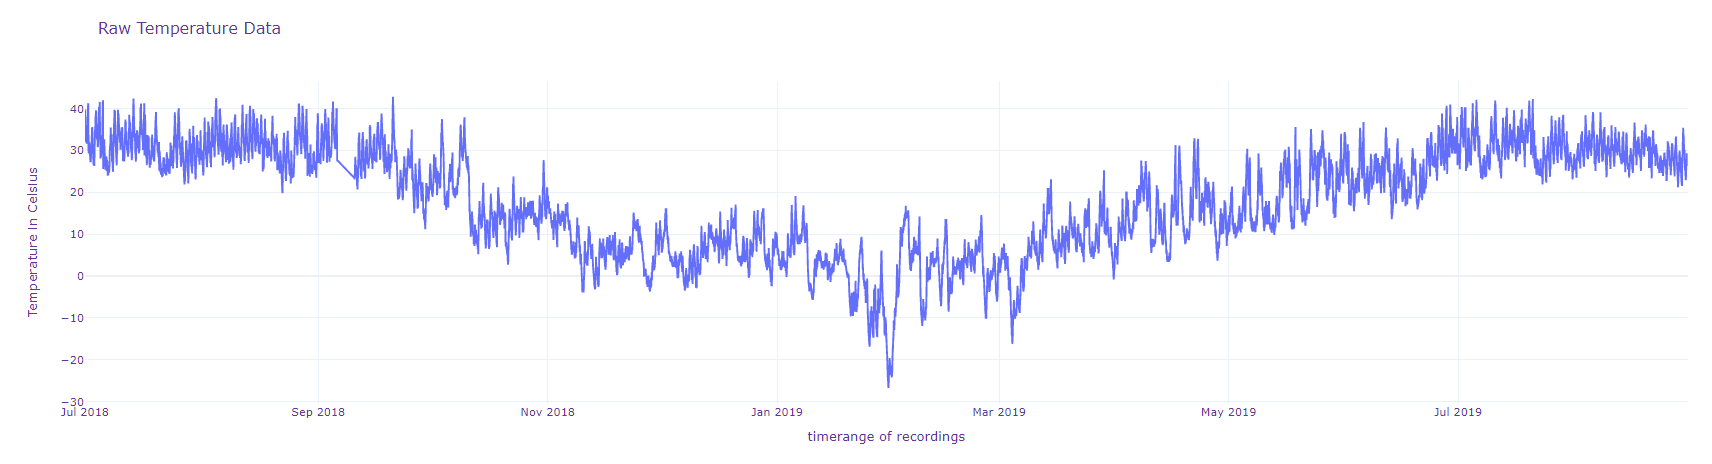

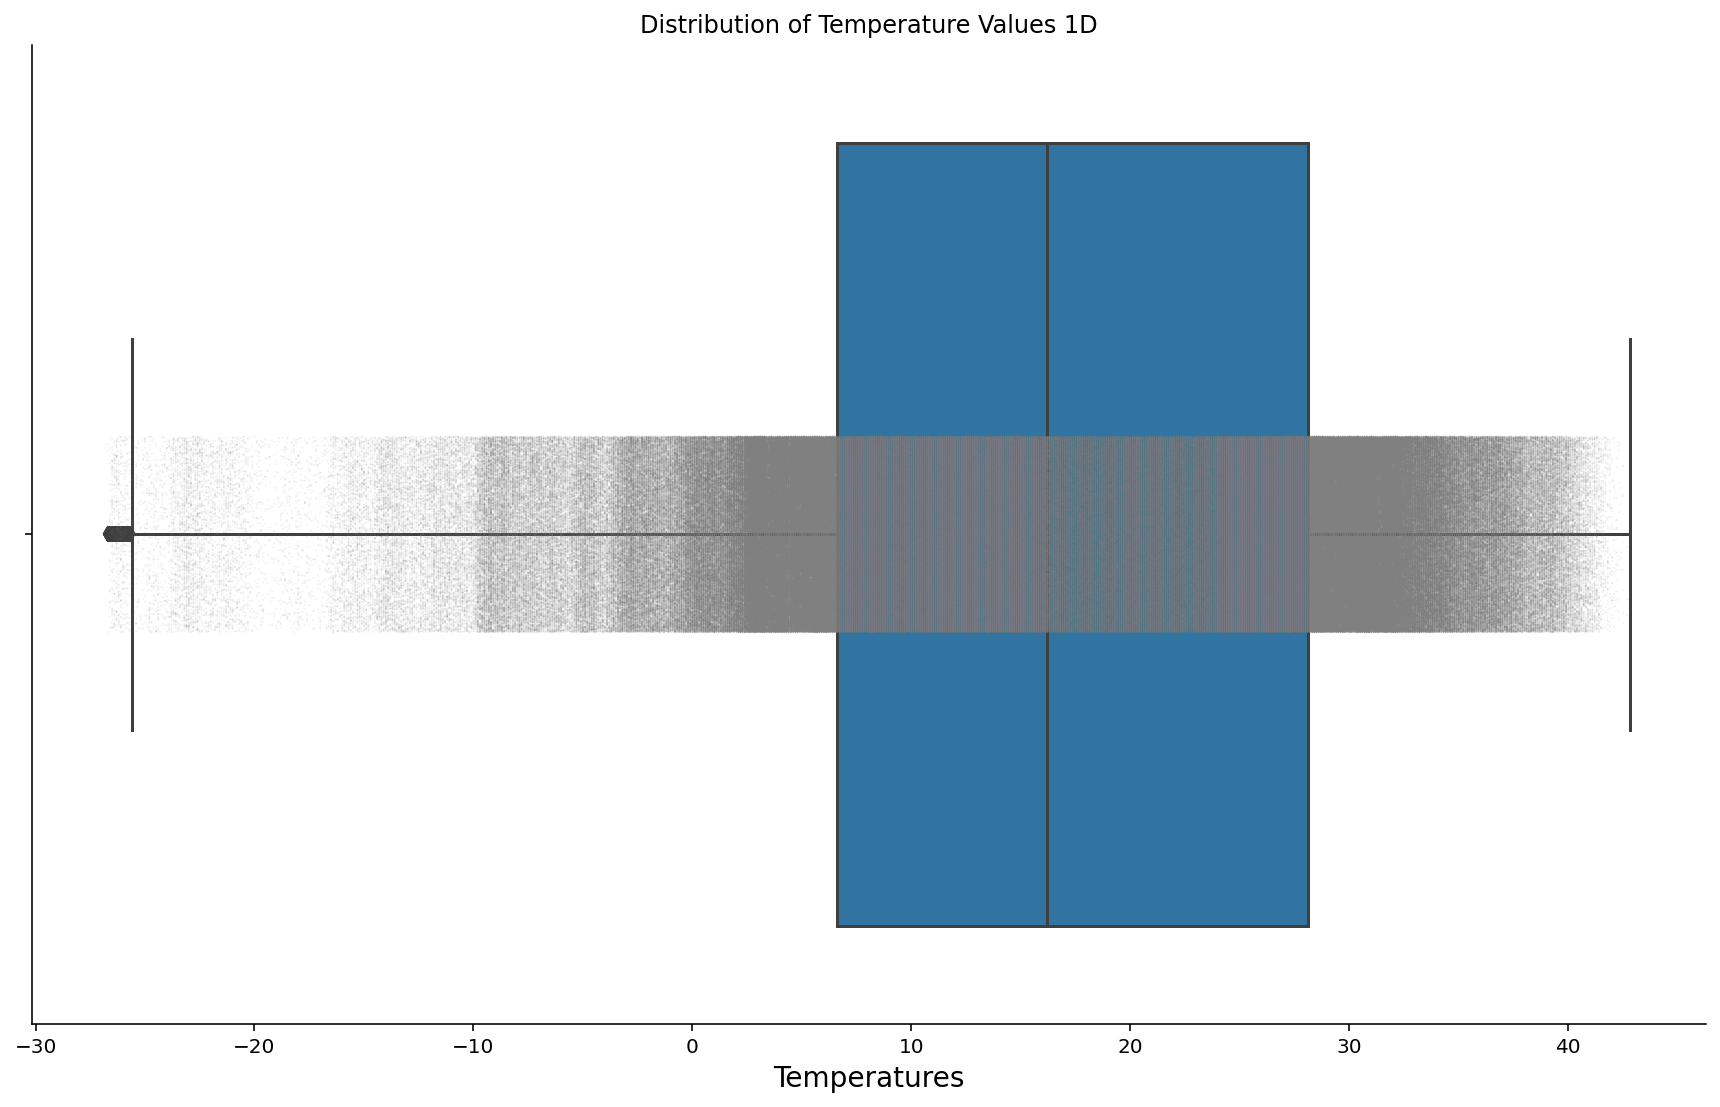

In [19]:
# Plotting the boxplot and values of the raw data:
plt.figure(figsize=(15,9))
sns.boxplot(x=tdf.value_hrf)
boxplot = sns.boxplot(x=tdf.value_hrf, showfliers=True)
boxplot = sns.stripplot(x=tdf.value_hrf, 
                        marker="o",
                        size=1,
                        alpha=0.1, 
                        color="grey")
boxplot.axes.set_title("Distribution of Temperature Values 1D", fontsize=12)
boxplot.set_xlabel("Temperatures", fontsize=14)
boxplot.set_ylabel("", fontsize=14)
sns.despine()
plt.show(); 
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis
# \\ENTER\\results\\histogram_isolation_forest.png', dpi=500)

In [20]:
#help(px.histogram)

In [21]:
# UNCOMMENT OUT IF YOU WANT TO SEE THE INTERACTIVE PLOT

# import plotly.express as px
# fig = px.histogram(x=tdf.value_hrf, 
#                    title='Sensor Temperature Histogram (1 year)', 
#                    labels=dict(x="Temperature (C)", y=" ")
#                     )
# fig.update_layout(showlegend=False,plot_bgcolor="white")
# fig.show()  # # data in Celsius
# fig.write_html('D:\histogram_rawdata.html')

In [22]:
print('Histogram of Sensor Temperature Readings:')

Histogram of Sensor Temperature Readings:


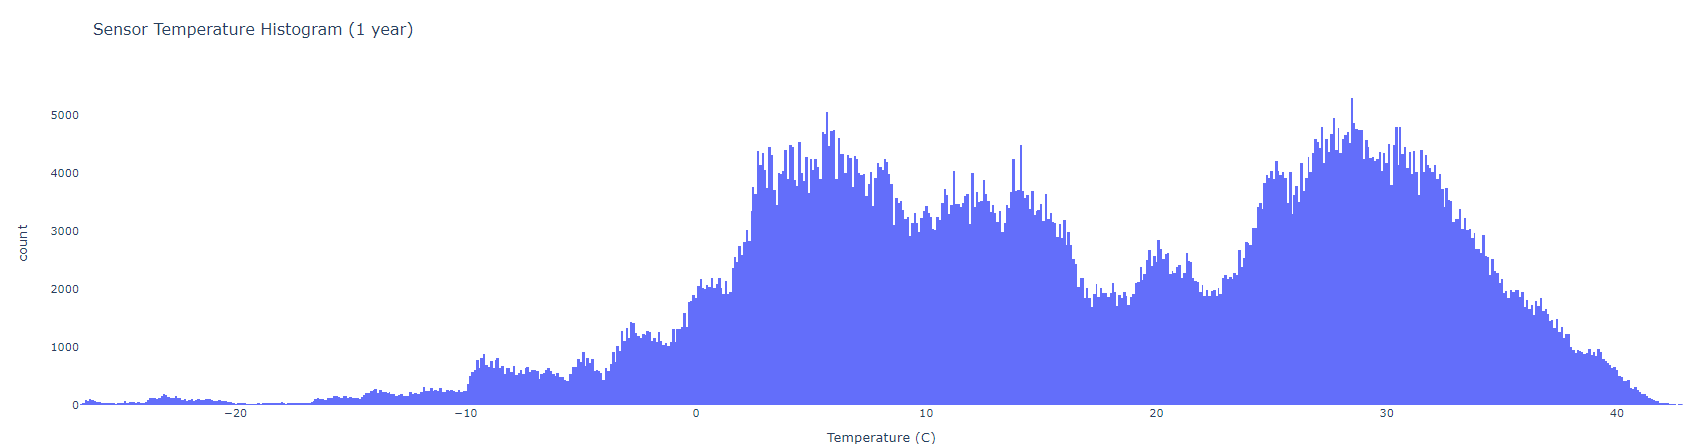

What do we really see here ? 
1. Outliers in general appear to be lower than about Celsius of -10
1. **Quad- modal** ?  (four major 'mountains')
1. Possibly we can break this temperature data down by kmeans cluster of FOUR ? 

<br>

---

# K-means Clustering Attempts

---

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [24]:
# type([tdf.value_hrf])   list

In [25]:
print('Example of reshaping into correct dimensions the X:')

Example of reshaping into correct dimensions the X:


In [26]:
tdf.value_hrf.values.reshape(-1,1)[:10]

array([[39.3],
       [39.4],
       [39.6],
       [39.5],
       [39.5],
       [39.4],
       [39.4],
       [39.3],
       [39.4],
       [39.4]])

In [27]:
X = StandardScaler().fit_transform(tdf.value_hrf.values.reshape(-1,1))

In [28]:
print('Your X is the following python type (you want numpy array)....', type(X))

Your X is the following python type (you want numpy array).... <class 'numpy.ndarray'>


In [29]:
print('Running k-means unsupervised machine learning model with assumption of 4 clusters:')

Running k-means unsupervised machine learning model with assumption of 4 clusters:


In [30]:

# creating k-means cluster model 

kmeans_model = KMeans(n_clusters=4, 
                      n_jobs=-1, 
                      random_state=42,
                      verbose=1).fit(X)

# algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
#     n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
#     random_state=0, tol=0.0001, verbose=0)

print("kmeans_model:\n", kmeans_model)

# K-Means, after placing K random centroids (initialization), the 
# data samples are repeatedly assigned to the nearest centroid
# and then centroid locations are updated. This continues until each 
# of the centroids coordinates converge, or stops changing...
#
# Thats why you see iterations and intertia calculated...
# 'Example':
#   'Converged at iteration 18: center shift 9.736828950943547e-05 
#   'within tolerance 9.999999999999994e-05.''


Initialization complete
Iteration 0, inertia 153443.87448819945
Iteration 1, inertia 130314.0038821485
Iteration 2, inertia 127930.2949175336
Iteration 3, inertia 126534.904094061
Iteration 4, inertia 125625.14646741457
Iteration 5, inertia 124659.14660509546
Iteration 6, inertia 123924.9048165895
Iteration 7, inertia 123325.76860545235
Iteration 8, inertia 122888.83158325333
Iteration 9, inertia 122604.92358231806
Iteration 10, inertia 122326.54477134439
Iteration 11, inertia 122069.37238784927
Iteration 12, inertia 121937.26299533051
Iteration 13, inertia 121814.7169107878
Iteration 14, inertia 121699.3983674895
Iteration 15, inertia 121626.18778775076
Iteration 16, inertia 121539.58905552127
Iteration 17, inertia 121480.49507848504
Iteration 18, inertia 121413.11097392502
Converged at iteration 18: center shift 9.736828950943547e-05 within tolerance 9.999999999999994e-05.
Initialization complete
Iteration 0, inertia 162988.51527997074
Iteration 1, inertia 129133.50948545408
Iteratio

---

**Side Observation:**
- It was eye-opening how long it takes to run k-means on a large dataset, it is not fundamentally a 'fast' algorithm
- MUST set your n_jobs to -1 to use all your computer cores ! 

---

In [106]:
print('Getting fancy:')

Getting fancy:


In [105]:
# for fun, lets prove that after the first initialization, 
# that it actually is truly converging on intertia
#
# take the values:
# Initialization complete
# Iteration 0, inertia 153443.87448819945
# Iteration 1, inertia 130314.0038821485
# Iteration 2, inertia 127930.2949175336
# Iteration 3, inertia 126534.904094061
# Iteration 4, inertia 125625.14646741457
# Iteration 5, inertia 124659.14660509546
# Iteration 6, inertia 123924.9048165895
# Iteration 7, inertia 123325.76860545235
# Iteration 8, inertia 122888.83158325333
# Iteration 9, inertia 122604.92358231806
# Iteration 10, inertia 122326.54477134439
# Iteration 11, inertia 122069.37238784927
# Iteration 12, inertia 121937.26299533051
# Iteration 13, inertia 121814.7169107878
# Iteration 14, inertia 121699.3983674895
# Iteration 15, inertia 121626.18778775076
# Iteration 16, inertia 121539.58905552127
# Iteration 17, inertia 121480.49507848504
# Iteration 18, inertia 121413.11097392502

# and plot!

In [215]:
print('I dont know why more people dont do stuff like this:')

I dont know why more people dont do stuff like this:


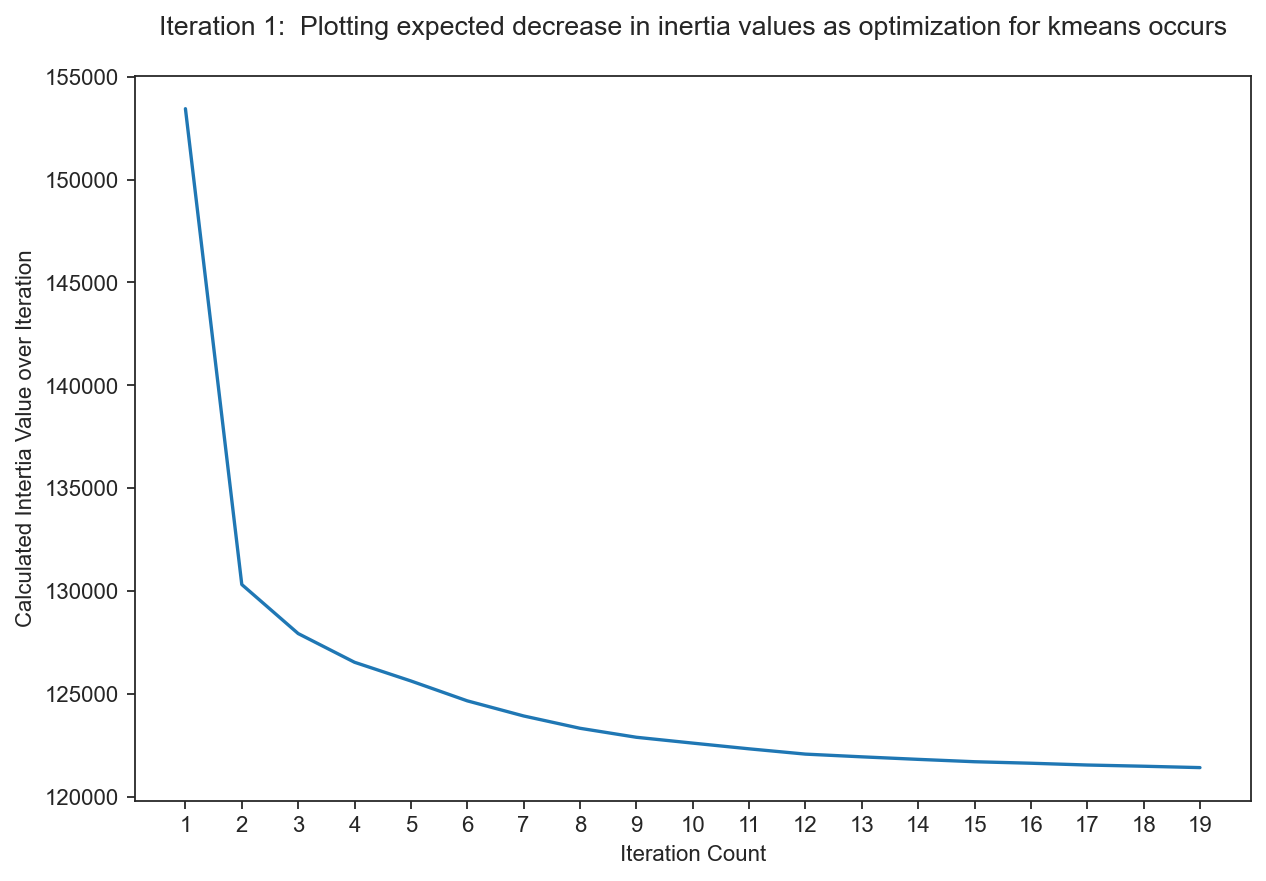

In [220]:

# take above kmeans scikit-learn verbose iteration output:

s = r"""Iteration 0, inertia 153443.87448819945
Iteration 1, inertia 130314.0038821485
Iteration 2, inertia 127930.2949175336
Iteration 3, inertia 126534.904094061
Iteration 4, inertia 125625.14646741457
Iteration 5, inertia 124659.14660509546
Iteration 6, inertia 123924.9048165895
Iteration 7, inertia 123325.76860545235
Iteration 8, inertia 122888.83158325333
Iteration 9, inertia 122604.92358231806
Iteration 10, inertia 122326.54477134439
Iteration 11, inertia 122069.37238784927
Iteration 12, inertia 121937.26299533051
Iteration 13, inertia 121814.7169107878
Iteration 14, inertia 121699.3983674895
Iteration 15, inertia 121626.18778775076
Iteration 16, inertia 121539.58905552127
Iteration 17, inertia 121480.49507848504
Iteration 18, inertia 121413.11097392502"""

magical_matching = re.findall('^.*[inertia\s]([0-9]+)[.,]?\d*$',s, re.MULTILINE)

x = range(1, len(magical_matching)+1)
y = list(map(int, magical_matching))
plt.figure(figsize=(9,6), dpi=80)
plt.xlabel("Iteration Count")
plt.ylabel("Calculated Intertia Value over Iteration")
# beautiful
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title("Iteration 1:  Plotting expected decrease in inertia values as optimization for kmeans occurs\n")
plt.plot(x,y)
plt.show();

# Ok, so thats how it works, makes sense ! 


In [221]:
# plotting the centroid locations
centers = kmeans_model.cluster_centers_
centers

array([[ 1.06001096],
       [-0.87110589],
       [-0.011274  ],
       [-1.84132648]])

In [223]:
# kmeans_model.n_iter_  
# thats why you see iteration 0-24 in some cases..

In [33]:
kmeans_model.n_clusters
# i created the model with 4 clusters 

4

In [34]:
kmeans_model

KMeans(n_clusters=4, n_jobs=-1, random_state=42, verbose=1)

In [224]:
print('K-means overall computed optimal inertia value for this assumption: ', kmeans_model.inertia_)

# measures how well a dataset was clustered by K-Means. 
# calculated by measuring the distance between each data point 
# and its centroid, squaring this distance, and summing these 
# squares across one cluster

# a good model is one with low inertia AND a low number of 
# clusters (K). However, this is a tradeoff because as K 
# increases, inertia decreases.

# to find the optimal K for a dataset, use the Elbow method
# find the point where the decrease in inertia begins to slow. 
# K=3 will be what we eventually find... 

# matches bottom of above graph...

# after placing K random centroids, the data samples are 
# repeatedly assigned to the nearest centroid and then 
# centroid locations are updated. This continues until
# each of the centroids’ coordinates converge, or stop changing... 


K-means overall computed optimal inertia value for this assumption:  121300.60813785985


In [75]:
print('\nK-Means Summary Table:\n')
print('iterations\tnum_clusters\tcalculated intertia')
print(kmeans_model.n_iter_, '\t\t', kmeans_model.n_clusters, '\t\t', f'{kmeans_model.inertia_:,}', '\n')
#       f'{len(tdf):,}'


K-Means Summary Table:

iterations	num_clusters	calculated intertia
24 		 4 		 121,300.60813785985 



## Plotting the k-mean cluster centroid locations...

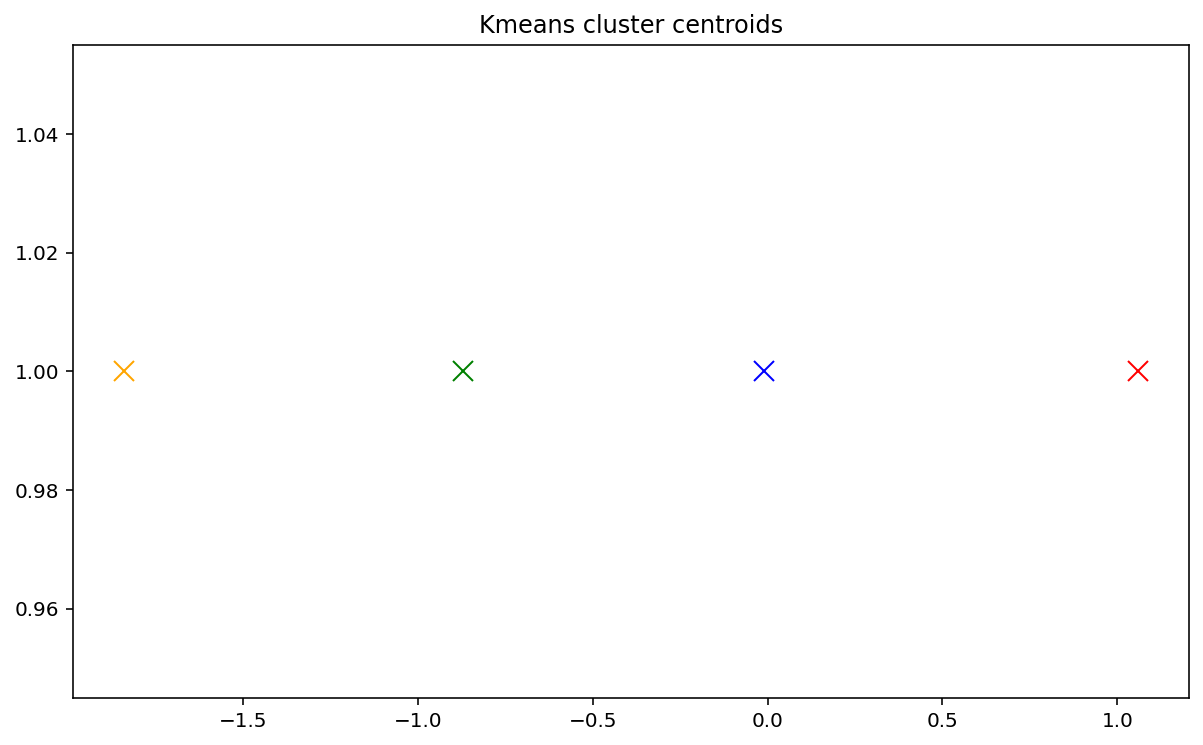

In [84]:

colors = ['r','g','b', 'orange']

centroids = kmeans_model.cluster_centers_

plt.figure(figsize=(10,6), dpi=60)

for n, y in enumerate(centroids):
    plt.plot(y, 1, marker='x', color=colors[n], ms=10)  

plt.title('K-means Calculated Cluster Centroid Locations(1D)'); 

# remember, these are standardscaler applied already


In [87]:
len(kmeans_model.labels_)
# we better have as many labels as we have observations ! :) 

1337728

In [88]:
len(tdf.value_hrf)

1337728

Assigning labels into dataframe for plotting:

In [79]:
# adding label to original df
tdf['assigned_cluster'] = kmeans_model.labels_

In [ ]:
tdf.tail(10)

Observations clustered into cluster by count:

In [97]:
print('Cl\tNumber of Observations')
print(tdf.assigned_cluster.value_counts())

Cl	Number of Observations
0    508598
1    405292
2    325727
3     98111
Name: assigned_cluster, dtype: int64


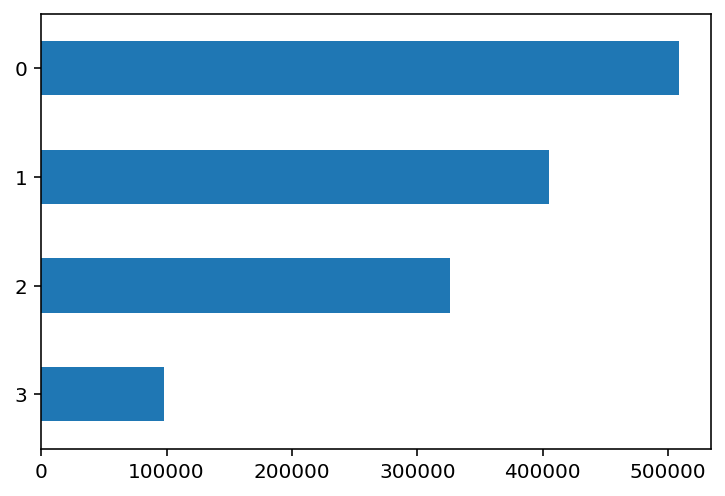

In [90]:
# how many samples fell into each cluster assignment ? 
tdf.assigned_cluster.value_counts().sort_values().plot(kind = 'barh'); 
# looks like cluster 3 is a somewhat smaller set...

In [102]:
print('Cleaner View:')
temp = tdf.assigned_cluster.value_counts().rename_axis('Assigned Cluster').reset_index(name='counts')
print(temp.to_string(index=False))

Cleaner View:
 Assigned Cluster  counts
                0  508598
                1  405292
                2  325727
                3   98111


In [ ]:
# don't need
# tdf['assigned_cluster'] = tdf['assigned_cluster'].astype(object)

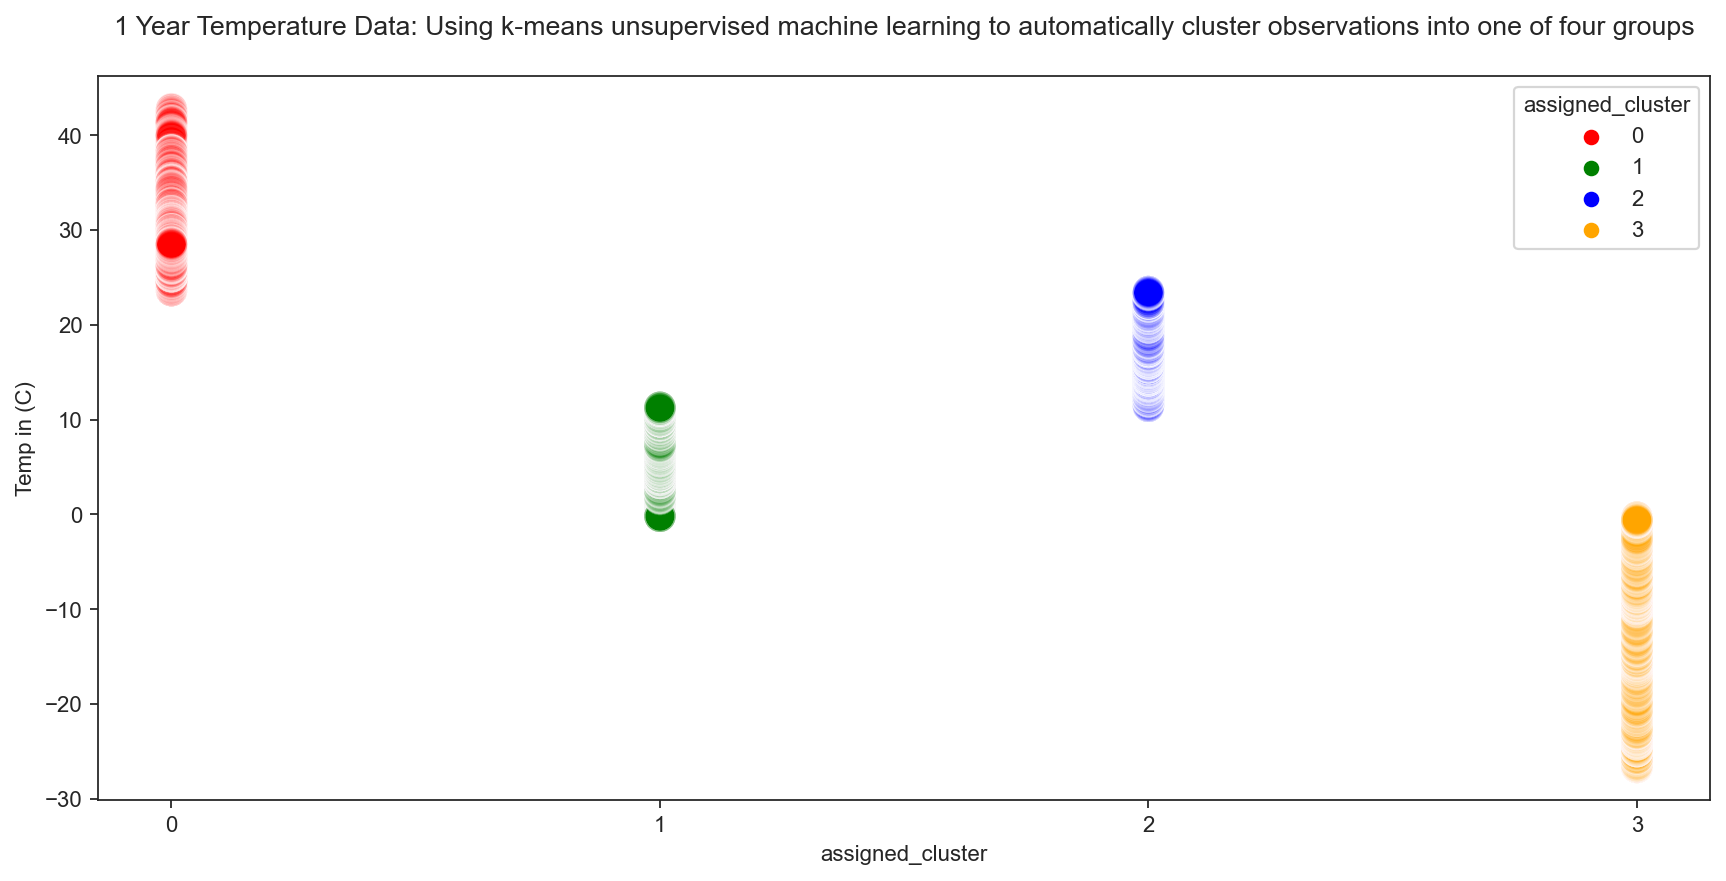

In [242]:
sns.set_style('ticks')
plt.figure(figsize=(13, 6), dpi=80)
sns.scatterplot(x='assigned_cluster', 
                y='value_hrf', 
                s=200, 
                alpha = 0.1,
                hue='assigned_cluster', 
                palette=['red', 'green', 'blue', 'orange'], 
                data=tdf);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.ylabel('Temp in (C)')
plt.title('1 Year Temperature Data: Using k-means unsupervised machine learning to automatically cluster observations into one of four groups\n');
                     
plt.savefig('D:\kmean_four_clusters_breakout.png', dpi=600);

In [ ]:
#  plt.savefig('D:\kmean_four_clusters_breakout.png', dpi=600);

In [ ]:
What do we see here ? 
1. cluster group 0 (the first) is probably what the majority of 'normal' temperature readings are
1. cluster group 1 appears to show a generalized 'cold' weather range, common for Chicago winters
1. cluster group 2 appears to show a small range 

In [ ]:
tdf.drop('assigned_cluster', axis=1, inplace=True) # when you are positive you are done

<br><br>

## Plotting the observations by the k-mean derived clusters (4):

###  Cluster: 0 

In [ ]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_cluster==0].index,  
#                                  y=tdf[tdf.assigned_cluster==0].value_hrf)])
                           
# fig = fig.update_layout(
#     title="K-Means Cluster: 0",
#     xaxis_title="Roughly Summer Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="red"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

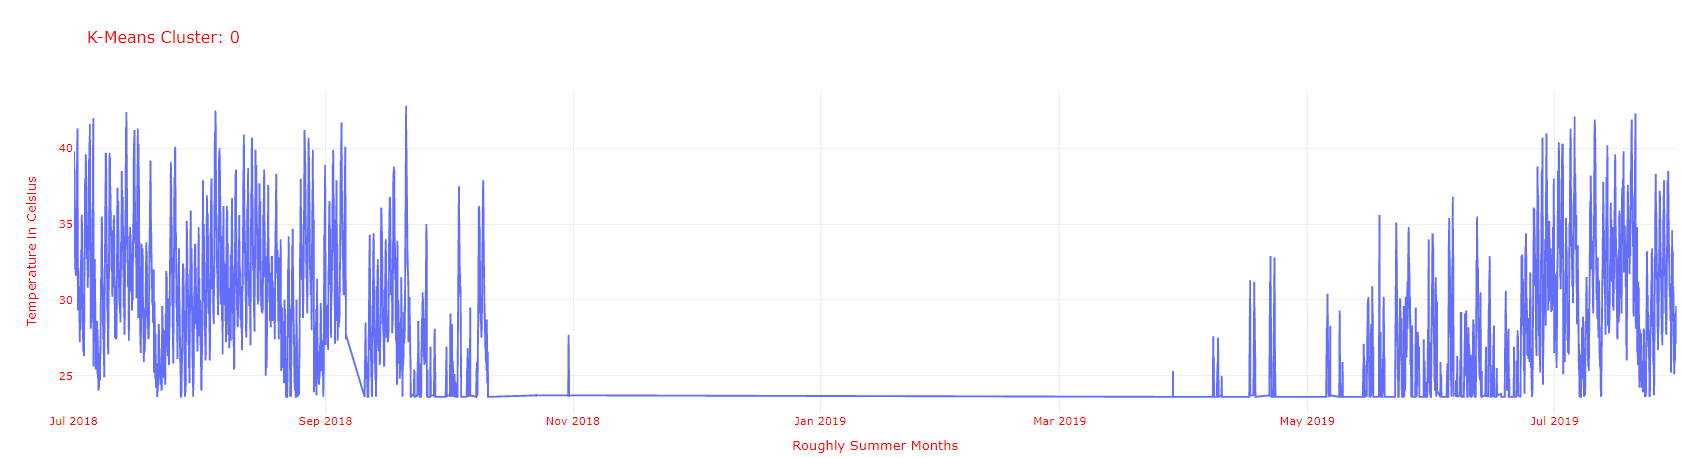

### Cluster: 1

In [ ]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_cluster==1].index,  
#                                  y=tdf[tdf.assigned_cluster==1].value_hrf)])
                           
# fig = fig.update_layout(
#     title="K-Means Cluster: 1",
#     xaxis_title="Roughly Generalized Winter Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="green"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

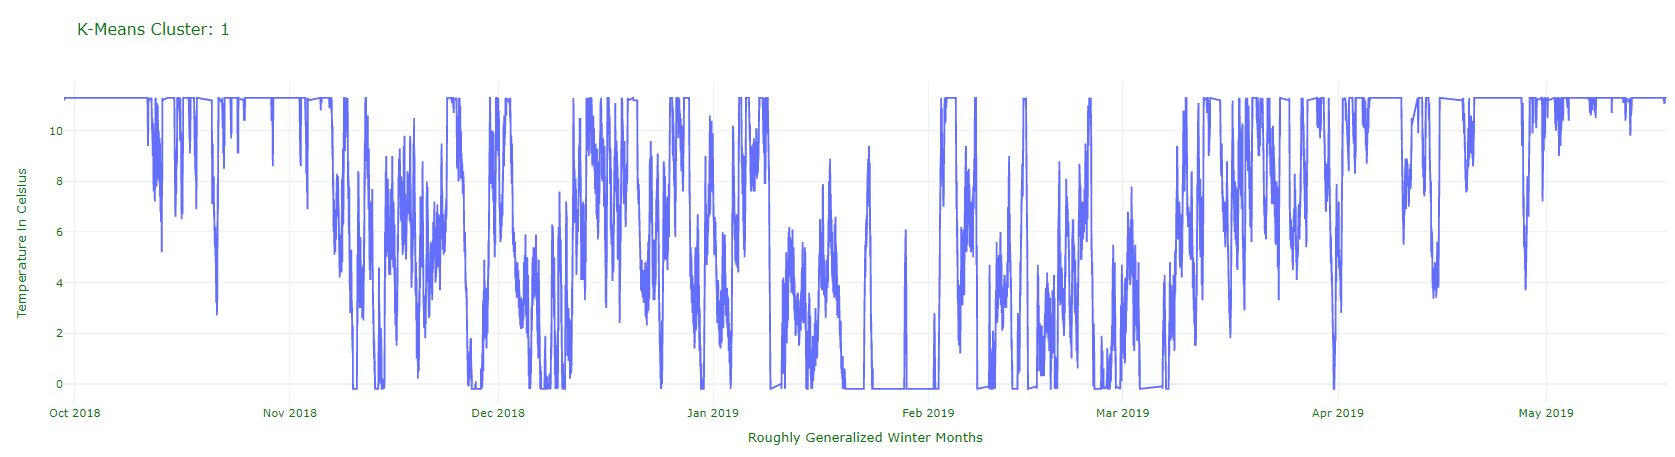

###  Cluster: 2 

In [ ]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_cluster==2].index,  
#                                  y=tdf[tdf.assigned_cluster==2].value_hrf)])
               
# fig = fig.update_layout(
#     title="K-Means Cluster: 2",
#     xaxis_title="Warmer Temperatures in parts of Fall and Later Spring Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="blue"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

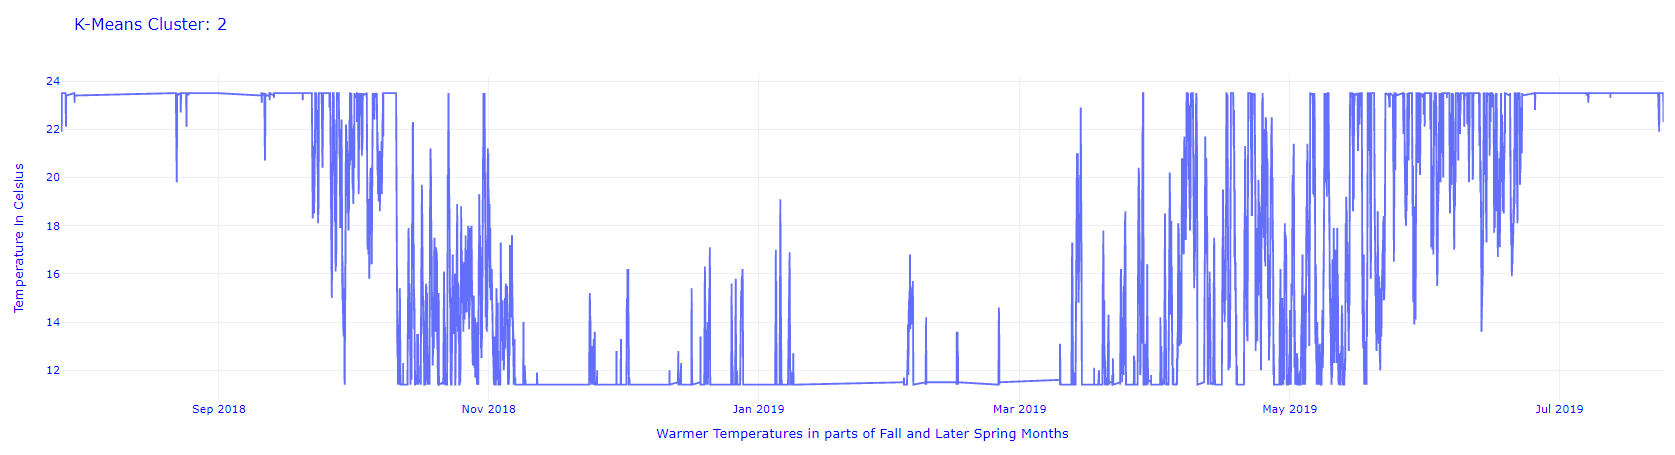

### Cluster: 3

In [ ]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_cluster==3].index,  
#                                  y=tdf[tdf.assigned_cluster==3].value_hrf)])
               
# fig = fig.update_layout(
#     title="K-Means Cluster: 3",
#     xaxis_title="Very Very Cold Region (Polar Vortex) Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="orange"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

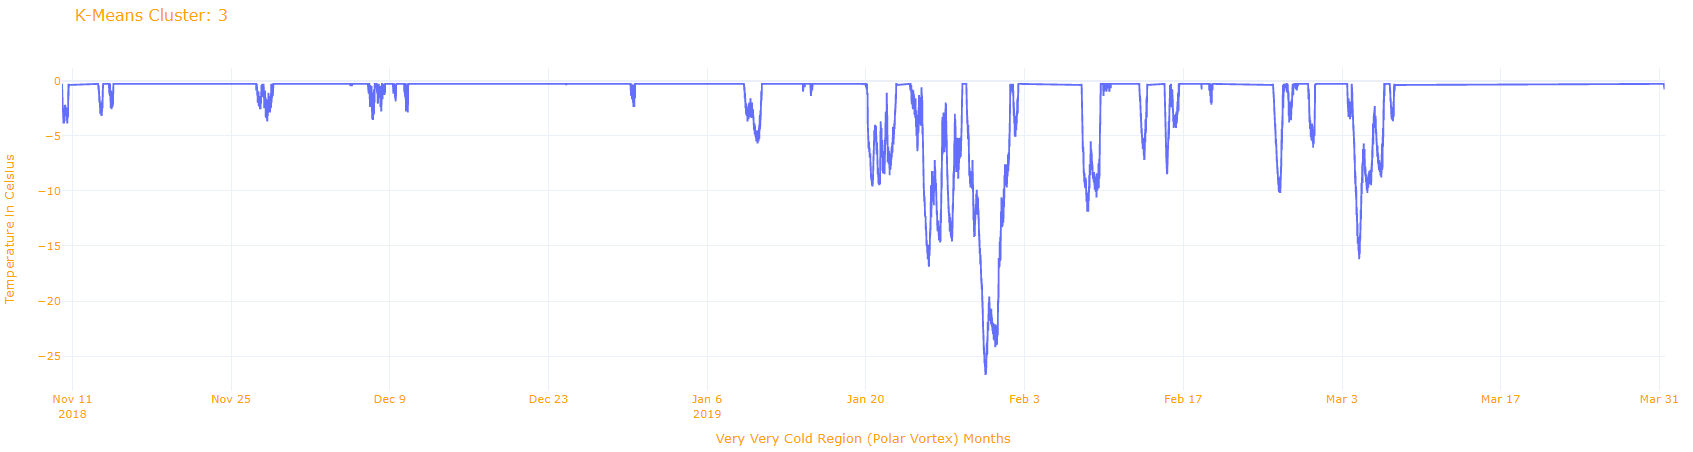

*Not bad, it captured some clustering concepts pretty well !*

---

---

## Plotting the observations by the k-mean derived clusters (6):

In [ ]:

kmeans_model = KMeans(n_clusters=6, 
                      n_jobs=-1, 
                      random_state=42,
                      verbose=0).fit(X)
print("kmeans_model:\n", kmeans_model)


In [ ]:
centers = kmeans_model.cluster_centers_
centers

In [ ]:
kmeans_model.n_iter_

In [ ]:
kmeans_model.n_clusters

In [ ]:
kmeans_model.cluster_centers_

In [ ]:
kmeans_model

# Plotting the k-mean cluster centroid locations...

In [ ]:
colors = ['r','g','b', 'orange', 'yellow', 'maroon']
centroids = kmeans_model.cluster_centers_
for n, y in enumerate(centroids):
    plt.plot(y, 1, marker='x', color=colors[n], ms=10)
plt.title('Kmeans cluster centroids'); 

In [ ]:
kmeans_model.inertia_

In [ ]:
# don't forget to remove previously added assigned_label column ! 
# tdf.drop('assigned_cluster', axis=1, inplace=True)
# already done...

In [ ]:
tdf.dtypes

In [ ]:
# adding label...
tdf['assigned_cluster'] = kmeans_model.labels_

In [ ]:
tdf.tail(10)

In [ ]:
tdf.assigned_cluster.value_counts()

In [ ]:
tdf.assigned_cluster.value_counts().sort_values().plot(kind = 'barh'); 

In [ ]:
# tdf['assigned_cluster'] = tdf['assigned_cluster'].astype(object)

In [ ]:
sns.set_style('ticks')
plt.figure(figsize=(12,8))
sns.scatterplot(x='assigned_cluster', 
                y='value_hrf', 
                s=100, 
                hue='assigned_cluster', 
                palette=['green','orange','brown','dodgerblue','red', 'yellow'], 
                data=tdf);
plt.savefig('D:\kmean_six_clusters_breakout.png', dpi=600);

It appears it broke it out into six clusters that stayed within certain ranges...

In [ ]:
tdf.drop('assigned_cluster', axis=1, inplace=True) # when you are positive you are done

<br><br>

# Starting Over:  What is optimal cluster count ? 

### Elbow Time

In [ ]:
score = []
for cluster in range(1,15):
    kmeans = KMeans(n_clusters = cluster, 
                    init="k-means++",
                    n_jobs=-1, 
                    random_state=42, 
                    verbose=0)
    kmeans.fit(X)
    score.append(kmeans.inertia_)

In [ ]:
# Elbow Plot:
import plotly.express as px
fig = px.line(x=range(1,15), y=score, title='Elbow Plot (clusters 1 - 15)', 
             width=700, height=500)
fig.show()

#WCSS on y-axis
#Cluster is 1-15

# it appears the ideal cluster count is actually 3... 

https://chart-studio.plotly.com/~saditham/12/elbow-curve-for-k-means-mini-batch-clustering/#/

https://plotly.com/python/setting-graph-size/
https://www.kaggle.com/abhishekyadav5/kmeans-clustering-with-elbow-method-and-silhouette

<br><br><br>

### Appendix:

In [239]:
# Getting really fancy: Do something like this ? 

# # Get this figure: fig = py.get_figure("https://plotly.com/~saditham/12/")
# # Get this figure's data: data = py.get_figure("https://plotly.com/~saditham/12/").get_data()
# # Add data to this figure: py.plot(Data([Scatter(x=[1, 2], y=[2, 3])]), filename ="elbow-kmeans-mini-batch", fileopt="extend")
# # Get y data of first trace: y1 = py.get_figure("https://plotly.com/~saditham/12/").get_data()[0]["y"]
# # Get figure documentation: https://plotly.com/python/get-requests/
# # Add data documentation: https://plotly.com/python/file-options/
# # If you're using unicode in your file, you may need to specify the encoding.
# # You can reproduce this figure in Python with the following code!
# # Learn about API authentication here: https://plotly.com/python/getting-started
# # Find your api_key here: https://plotly.com/settings/api
# #-------------------------------------------------------------------------------

# # import plotly.plotly as py
# # from plotly.graph_objs import *
# # py.sign_in('username', 'api_key')
# # trace1 = {
# #   "uid": "fa6c4ce6-9914-11e8-b54d-acde48001122", 
# #   "name": "Elbow curve for k means mini-batch clustering", 
# #   "type": "scatter", 
# #   "x": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 
# #   "y": [64.70056264831679, 29.037118394427466, 19.662242515207108, 
# #        17.607916888086383, 14.155652969913112, 12.662192837018376, 11.583273153679954, 10.531310534276557, 
# #        9.409802688171558, 9.357585569788831, 8.520543339024417, 8.389996105300312, 7.34470971663154, 
# #        7.116539048873555, 6.941278833762319, 6.501513732695154, 6.661729384647086, 6.502539891095247, 
# #        5.988128002466148, 6.4919623671444855, 5.753640575557243, 5.581021726358823, 5.570002561391658,
# #        5.173486970375118, 5.037153702267087, 5.382110102012841, 4.884468608819716, 4.78856205462475,
# #        4.891412108035984]
# # }

# # data = Data([trace1])

# layout = {
#   "title": "Elbow curve for k means mini-batch clustering", 
#   "xaxis": {
#     "title": "K value", 
#     "titlefont": {
#       "size": 18, 
#       "color": "#7f7f7f", 
#       "family": "Courier New, monospace"
#     }
#   }, 
#   "yaxis": {
#     "title": "Distortions", 
#     "titlefont": {
#       "size": 18, 
#       "color": "#7f7f7f", 
#       "family": "Courier New, monospace"
#     }
#   }
# }

# fig = Figure(data=data, 
#              layout=layout)
# plot_url = py.plot(fig)


In [ ]:
# THIS WORKS BUT HAS HUGE HUGE OUTPUT:


# --- PLOTS ALL OF THE DATA AND IDENTIFIED ANOMALIES IN PLOTLY, FULLY INTERACTIVE ---
# uncomment out if you want to see it...


# fig = go.Figure(data=[original_data, anomalies_red], layout=layout)

# fig = fig.update_layout(title="Anomalies determined with Isolation Forest - Single Sensor - Chicago Region", 
#                        template="plotly_dark", 
#                        yaxis_title='Temperature in Celsius')
# LAUNCHES:
# iplot(fig)

# SAVING / EXPORTING: 
# works:  iplot(fig, image='svg', filename='D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_final_AD_plotted_2.svg')


# interesting:  this seems to export just fine but sometimes you have to do it twice:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isolation_forest_final_AD_plotted_superhighres.html")


# fig.write_image("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isol_forest_final_AD_plotted.svg")
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\histogram_anomaly_scores_isolation_forest.png', dpi=800)
# fig.write_html("isolation_forest_working_high_resolution.html")



In [ ]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(n_estimators=100, 
#                     max_samples='auto', 
#                     contamination=float(.01), 
#                     max_features=1.0, 
#                     bootstrap=False, 
#                     n_jobs=-1, 
#                     random_state=42, 
#                     verbose=1)
# clf.fit(tdf[['value_hrf']])  # since 1D ! 
# # The predict function classifies the data as anomalies 
# # based on the results from decision function on crossing a threshold
# tdf['scores']=clf.decision_function(tdf[['value_hrf']])
# #tdf['anomaly']=clf.predict(tdf[['value_hrf']])
# #tdf.loc[tdf['anomaly'] == 1,'anomaly'] = 0
# #tdf.loc[tdf['anomaly'] == -1,'anomaly'] = 1
# ## classified as -1 is 'anomalous'
# #tdf.anomaly.value_counts()
# pred = clf.predict(tdf[['value_hrf']])
# tdf['anomaly']=pred
# outliers=tdf.loc[tdf['anomaly']==-1]
# outlier_index=list(outliers.index)
# #Find the number of anomalies and normal points here points classified -1 are anomalous
# print(tdf['anomaly'].value_counts())
# IsolationForest(contamination=0.01, n_jobs=-1, random_state=42, verbose=1)
#  1    86706
# -1      857
# Name: anomaly, dtype: int64
# print("Percentage of anomalies in data: {:.2f}".format((len(tdf.loc[tdf['anomaly']==-1])/len(tdf))*100))

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline
# # sns.set(style="darkgrid")
# fig, ax = plt.subplots(figsize=(15,10))
# sns.histplot(data=tdf, x="scores")
# plt.show(); 